In [1]:
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")


df = pd.read_csv(os.getenv("ZSCORED"),index_col=0)


In [2]:
clinical_df = pd.read_csv(os.getenv("CLINICAL"), index_col=0)

In [10]:
# Sanity check — how many match?
matching = clinical_df["title"].isin(df.index).sum()
print(f"Matching samples: {matching} / {len(clinical_df)}")


Matching samples: 3409 / 3409


In [11]:
# Set title as index
clinical_df_indexed = clinical_df.set_index("title")

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]


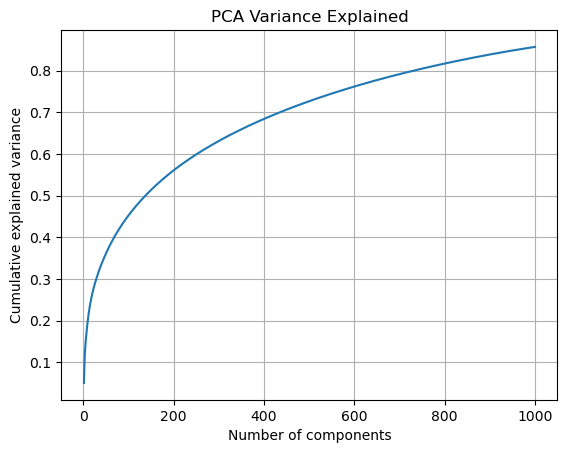

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)  # start big
X_pca = pca.fit_transform(df)

# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Variance Explained")
plt.grid(True)
plt.show()


In [14]:
from sklearn.decomposition import PCA

# 2-component PCA for visualization
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(df)

print(f"Explained variance ratio (2D): {pca2.explained_variance_ratio_}")
print(f"Cumulative variance: {pca2.explained_variance_ratio_.sum():.2%}")


Explained variance ratio (2D): [0.05052829 0.04253825]
Cumulative variance: 9.31%


In [17]:
# Check variance per gene
gene_variances = df.var()

# How many genes have almost no variance?
low_variance_genes = (gene_variances < 1e-5).sum()
print(f"Number of near-zero variance genes: {low_variance_genes} / {df.shape[1]}")


Number of near-zero variance genes: 4 / 26148


In [18]:
print("Top 5 most variable genes:")
print(gene_variances.sort_values(ascending=False).head())


Top 5 most variable genes:
DDX53         1.000293
MAGEA8-AS1    1.000293
HTR2C         1.000293
MAGEA3        1.000293
MAGEA6        1.000293
dtype: float64


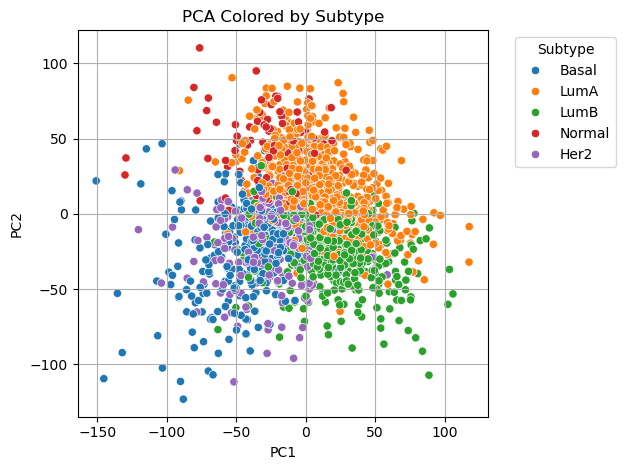

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Set 'title' as index in clinical_df
clinical_df_indexed = clinical_df.set_index("title")

# Step 2: Create PCA DataFrame using expression_df's index (which should match title)
pca_df = pd.DataFrame(X_pca2, columns=["PC1", "PC2"], index=expression_df.index)

# Step 3: Join PCA results with clinical metadata
pca_df = pca_df.join(clinical_df_indexed)

# Step 4: Plot PCA colored by subtype (adjust column name if needed)
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="characteristics_ch1.20.pam50 subtype", palette="tab10")
plt.title("PCA Colored by Subtype")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

# Reduce to 50 components (or use n_components_90 as discussed)
pca = PCA(n_components=3)
X_pca_kmeans = pca.fit_transform(expression_df)


# Set number of clusters (e.g. 5, since we have 5 subtypes)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca_kmeans)


In [21]:
pca_df["Cluster"] = cluster_labels  # assumes pca_df indexed by sample_id/title


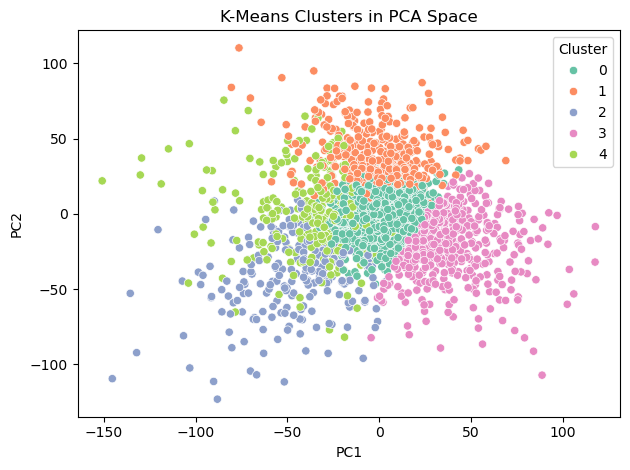

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2")
plt.title("K-Means Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(pca_df["characteristics_ch1.20.pam50 subtype"], pca_df["Cluster"])
print(f"Adjusted Rand Index (ARI): {ari:.3f}")


Adjusted Rand Index (ARI): 0.094


## Remove Outliers

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Compute z-scores across each gene (column-wise)
z_scores = df.apply(zscore, axis=0)

# Get max absolute z-score per sample
max_abs_z_per_sample = z_scores.abs().max(axis=1)

# Parameters
z_threshold = 10
max_allowed_extreme_genes = 10  # tweak this as needed

# Count number of extreme genes per sample
n_extreme_per_sample = (z_scores.abs() > z_threshold).sum(axis=1)

# Filter samples with acceptable number of outlier genes
df_filtered = df[n_extreme_per_sample <= max_allowed_extreme_genes]


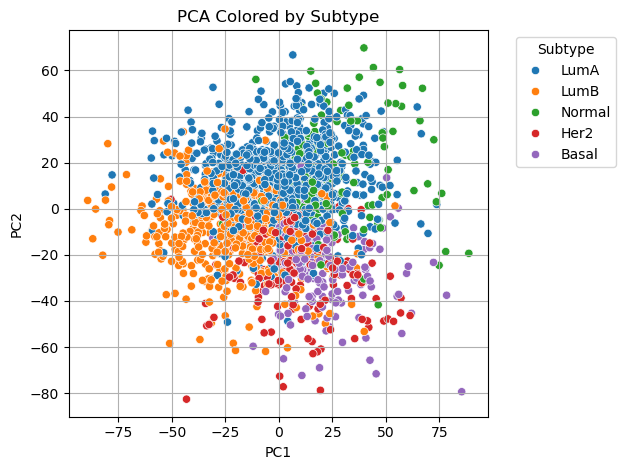

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(df_filtered)

# Step 1: Set 'title' as index in clinical_df
clinical_df_indexed = clinical_df.set_index("title")

# Step 2: Create PCA DataFrame using expression_df's index (which should match title)
pca_df = pd.DataFrame(X_pca2, columns=["PC1", "PC2"], index=df_filtered.index)

# Step 3: Join PCA results with clinical metadata
pca_df = pca_df.join(clinical_df_indexed)

# Step 4: Plot PCA colored by subtype (adjust column name if needed)
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="characteristics_ch1.20.pam50 subtype", palette="tab10")
plt.title("PCA Colored by Subtype")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
